# Visualization of downstream results

In [13]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.decomposition import PCA
import anndata as ad
import scanpy as sc

In [14]:
# Define base directory and map experiments to run IDs
mlrun_dir = "mlruns"
name_id_mapping = {'random (GPU)': '2',
                   'seeds (GPU)': '1',
                   'deterministic (GPU)': '4',
                   'random (CPU)': '3'}

# Get dict of embeddings

In [15]:
keys = list(name_id_mapping.keys())

exp_dict = {}
for k in keys:
    emb_list = []
    experiment_path = os.path.join(mlrun_dir, name_id_mapping[k])
    runs = os.listdir(experiment_path)
    runs = [x for x in runs if not x == 'meta.yaml']
    runs = [x for x in runs if not x == '.DS_Store']

    for i, run in enumerate(runs):
        emb = pd.read_csv(os.path.join(experiment_path, run, 'artifacts/embedding.png.csv'), index_col=0)
        emb_list.append(emb)
        emb['run'] = ['run' + str(i)] * emb.shape[0]
    
    exp_dict[k] = pd.concat(emb_list)


# Make UMAP plots

random (GPU)
seeds (GPU)
deterministic (GPU)
random (CPU)


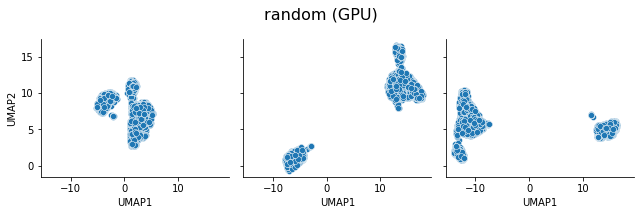

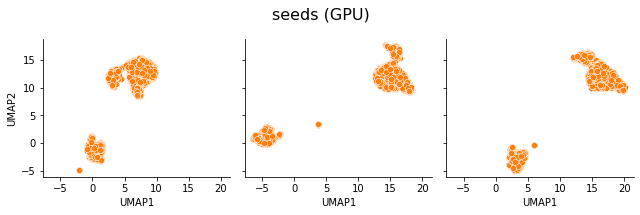

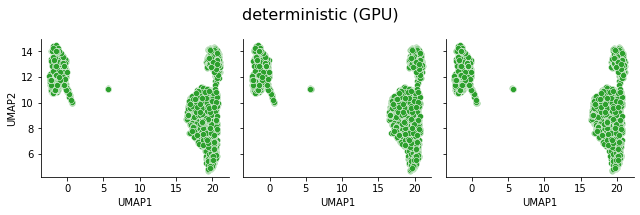

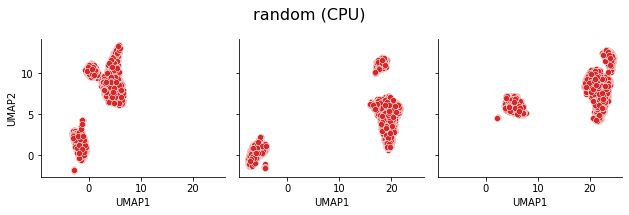

In [16]:
# Run UMAP for all the different runs of an experiment
for key in exp_dict.keys():
    print(key)
    
    color = sns.color_palette()[0]
    if key == "seeds (GPU)":
        color = sns.color_palette()[1]
    if key == "deterministic (GPU)":
        color = sns.color_palette()[2]
    if key == "random (CPU)":
        color = sns.color_palette()[3]
    
    title = key    
    
    exp = exp_dict[key]
    runs = list(set(exp.run))
    umap_list = []
    run_count = 0
    for run in runs:
        if run_count == 3:
            break
        run_count += 1
        tmp = exp[exp['run'] == run].copy()
        tmp.drop('run', axis=1, inplace=True)

        reducer = umap.UMAP(random_state=42)
        embedding = reducer.fit_transform(tmp.to_numpy())
        df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
        df['run'] = [run]*df.shape[0]
        umap_list.append(df)

    df = pd.concat(umap_list)
    
    # Make the plot and save
    g = sns.FacetGrid(df, col='run', col_wrap=3)
    g.map(sns.scatterplot, "UMAP1", "UMAP2", color=color)
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(title, fontsize=16)
    axes = g.axes.flatten()
    [ax.set_title("") for ax in axes]
    plt.tight_layout()
    plt.savefig(f"plots/{key}_UMAP.png")

# Perform clustering of cells

In [5]:
def get_most_common_cluster_pct(df):
    # For each cell, gets the pct of cells that are assigned to the most common cluster
    # in several runs
    n_runs = df.shape[0]
    pcts = []
    for i in range(df.shape[1]):
        cell = list(df[i])
        most_common = max(set(cell), key=cell.count)
        n_most_common = cell.count(most_common)
        pct = n_most_common / n_runs
        pcts.append(pct)
    
    return pcts

keys = list(name_id_mapping.keys())
adata_dict = {}
for k in keys:
    adata_list = []
    experiment_path = os.path.join(mlrun_dir, name_id_mapping[k])
    runs = os.listdir(experiment_path)
    runs = [x for x in runs if not x == 'meta.yaml']
    runs = [x for x in runs if not x == '.DS_Store']

    for i, run in enumerate(runs):
        adata = ad.read_csv(os.path.join(experiment_path, run, 'artifacts/embedding.png.csv'), first_column_names=True)
        adata = adata[1:,:] # remove the first row / artifact from reading the data like that
        adata_list.append(adata)
    
    adata_dict[k] = adata_list

In [6]:
# Perform leiden clustering with every embedding
cluster_dict = {}
for key in adata_dict.keys():
    
    print(key)

    cluster_list = []
    experiment = adata_dict[key]
    for adata in experiment:
        # Perform leiden clustering
        sc.pp.neighbors(adata)
        sc.tl.leiden(adata)
        cluster_list.append(list(adata.obs.leiden))
    
    df = pd.DataFrame(cluster_list)
    cluster_dict[key] = df

random (GPU)
seeds (GPU)
deterministic (GPU)
random (CPU)


## Compare cluster sizes
Differences in clustering due to non-deterministic settings will result in slight changes of cluster sizes, which we will visualize here.

In [7]:
df_list = []
for key in adata_dict.keys():
    print(key)
    df = cluster_dict[key]
    
    tmp_list = []
    for i in range(df.shape[0]):
        tmp = df.iloc[i,:].copy()
        tmp = pd.DataFrame(tmp.value_counts())
        tmp_list.append(tmp)
    
    clust_df = pd.concat(tmp_list, axis=1)
    clust_df['cluster'] = list(range(clust_df.shape[0]))
    clust_df['experiment'] = [key]*clust_df.shape[0]
    clust_df = pd.melt(clust_df, id_vars = ['experiment','cluster'])
    clust_df.columns = ['experiment', 'cluster', 'run', 'size']
    df_list.append(clust_df)

df = pd.concat(df_list)

random (GPU)
seeds (GPU)
deterministic (GPU)
random (CPU)


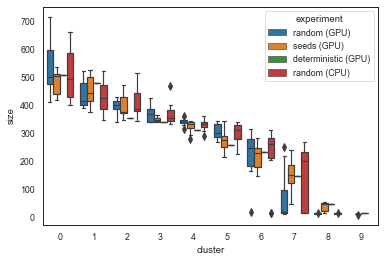

In [8]:
# make the plot
sns.set_style("white")
sns.set_context("paper")
#sns.set_palette("Set2")
ax = sns.boxplot(x='cluster', y='size', hue='experiment', data=df)
plt.savefig("plots/cluster_size_boxplot.png")